In [70]:
%load_ext autoreload 
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist

plt.style.use("seaborn-v0_8")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
torch.manual_seed(0)
pyro.set_rng_seed(0)
μ = torch.tensor([-20., 20])
π = torch.tensor([0.3, 0.7])
Σ = torch.ones(2) * 10.
N = 100
clusters = torch.multinomial(π, N, replacement=True)

In [72]:
clusters

tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1])

In [73]:
comp_dist =[dist.Normal(μ[i], Σ[i]) for i in range(len(μ))]
comp_dist

[Normal(loc: -20.0, scale: 10.0), Normal(loc: 20.0, scale: 10.0)]

In [74]:
samples = torch.tensor([comp_dist[i].sample().item() for i in clusters ])
samples

tensor([ 33.4407,  43.8322,  14.3354,   8.4638,  -5.0230,  28.7556, -46.7257,
         19.6867,  24.9879, -25.2332,  17.4852, -30.5553,  14.4074,  18.8029,
         18.3645,  17.4954,   9.1178, -19.9559,  22.3279,  11.7986, -26.7902,
         34.2508,  -0.3525,  27.6784,  -0.1009,  27.1825,  15.0333,  33.1003,
         23.9556, -19.1052,  18.3179,  15.2724, -39.7058, -13.7192,  18.8685,
         24.6311,  23.3380,  36.4432,   7.4652,  19.4084,  -8.1215,  -7.7526,
         11.4788,   8.0591,  31.0757,  26.5780,  19.5768, -15.4196,  21.4480,
          5.8052,  40.4391, -10.3619, -16.7219,   5.5579,   6.1648,  12.0133,
         10.7241,  27.7495,  -7.6309,  12.3015,  10.0820,  -3.0175, -18.8416,
         10.7737,  30.2725, -31.2103,  27.3075,  19.5605,  -8.3658,  21.5196,
         27.0913,  24.0722,   0.6170,   7.2007, -33.4824, -19.3977, -22.9735,
         -4.5381,  15.6918, -25.2539, -24.7669,  36.9499,  23.4745, -14.1965,
         18.7110,  30.0629,  25.3378,  19.1879,  15.0491,  -0.67

In [75]:
probs = torch.tensor([ π[0] * comp_dist[0].log_prob(samples[j]).exp() +  π[1] * comp_dist[1].log_prob(samples[j]).exp()
         for j in range(len(samples))])
probs

tensor([0.0113, 0.0016, 0.0238, 0.0146, 0.0051, 0.0190, 0.0003, 0.0279, 0.0247,
        0.0104, 0.0271, 0.0069, 0.0239, 0.0277, 0.0276, 0.0271, 0.0156, 0.0120,
        0.0272, 0.0200, 0.0095, 0.0101, 0.0053, 0.0208, 0.0054, 0.0216, 0.0247,
        0.0118, 0.0258, 0.0119, 0.0275, 0.0250, 0.0017, 0.0099, 0.0278, 0.0251,
        0.0264, 0.0072, 0.0130, 0.0279, 0.0064, 0.0062, 0.0195, 0.0139, 0.0151,
        0.0225, 0.0279, 0.0108, 0.0276, 0.0106, 0.0035, 0.0078, 0.0114, 0.0103,
        0.0111, 0.0204, 0.0183, 0.0207, 0.0062, 0.0208, 0.0172, 0.0048, 0.0119,
        0.0184, 0.0165, 0.0064, 0.0214, 0.0279, 0.0066, 0.0276, 0.0217, 0.0257,
        0.0057, 0.0126, 0.0048, 0.0120, 0.0115, 0.0050, 0.0255, 0.0104, 0.0107,
        0.0066, 0.0263, 0.0102, 0.0277, 0.0168, 0.0242, 0.0278, 0.0247, 0.0051,
        0.0086, 0.0235, 0.0275, 0.0113, 0.0188, 0.0097, 0.0119, 0.0009, 0.0195,
        0.0128])

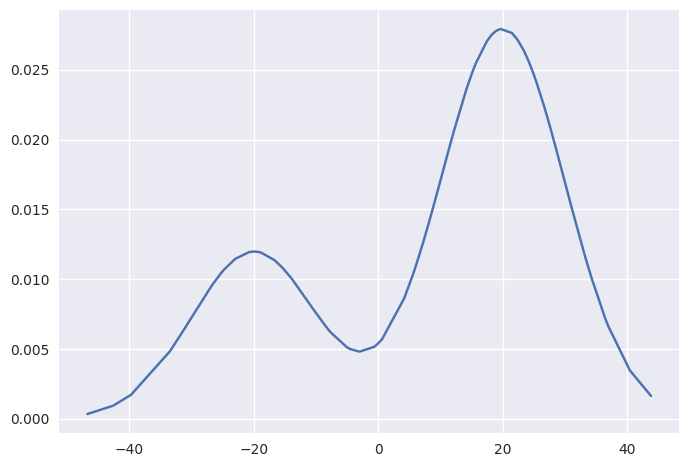

In [76]:
plt.plot(torch.sort(samples).values, probs.gather(0, torch.argsort(samples)), )

In [77]:
def metropolis(target, proposal, num_steps=1000, seed=None, return_probs=False):
    if seed is not None:
        torch.manual_seed(seed)
        pyro.set_rng_seed(seed)
    x = torch.tensor(0.)
    s = 0
    unif = dist.Uniform(0, 1)
    samples = {"x": [], "probs": []}

    while s < num_steps:
        u = unif.sample()
        xhat = proposal.sample()
        ratio =  target.log_prob(xhat) - target.log_prob(x) 
        ratio += proposal.log_prob(x) - proposal.log_prob(xhat)
        ratio.exp_()
        # print(u, ratio)
        ratio.clip_(max=1)
        if ratio >= u:
            x = xhat
            samples["x"].append(x)
            samples["probs"].append(target.log_prob(x).exp())
        s += 1 
    
    data = torch.vstack(samples["x"]).flatten()
    if return_probs:
        data = data, torch.vstack(samples["probs"]).flatten()
    
    return data

In [78]:
def gmm_target():
    
    class GMM:
        
        def __init__(self) -> None:
            self.comp_dist = comp_dist
            self.pi = π 
            
            assert len(self.pi) == len(self.comp_dist)
            assert sum(self.pi) == 1
            
        def log_prob(self, x):
            probs = sum([self.pi[i] * self.comp_dist[i].log_prob(x).exp() for i in range(len(self.pi))])
            # print("GMM Sample x", x, "probs: ", probs)

            return torch.as_tensor(probs).log()
        
    
    return GMM()

In [79]:
def visualize(target, q, num_steps=1000, seed=10):
    s, p = metropolis(target, q, num_steps, seed=seed, return_probs=True)
    fig, ax = plt.subplots()
    ax.plot(torch.sort(samples).values, probs.gather(0, torch.argsort(samples)), label="target")
    ax.plot(s.sort().values, p.take(s.sort()[1]), label="metropolis")
    ax.legend()

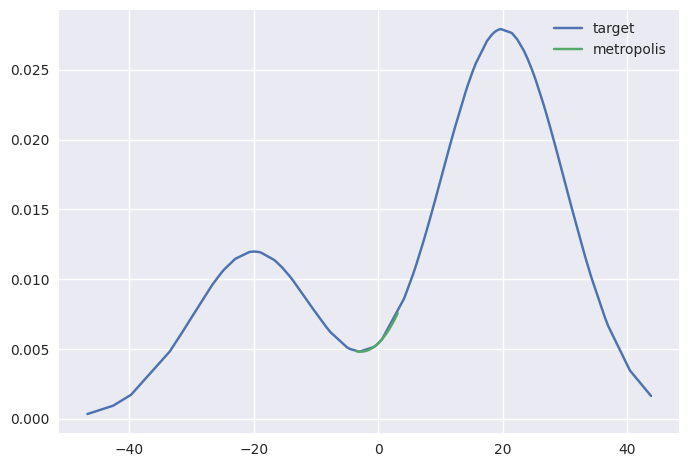

In [80]:
τ = torch.tensor(1.)
q = dist.Normal(0, τ)
target = gmm_target()
visualize(target, q, 1000)

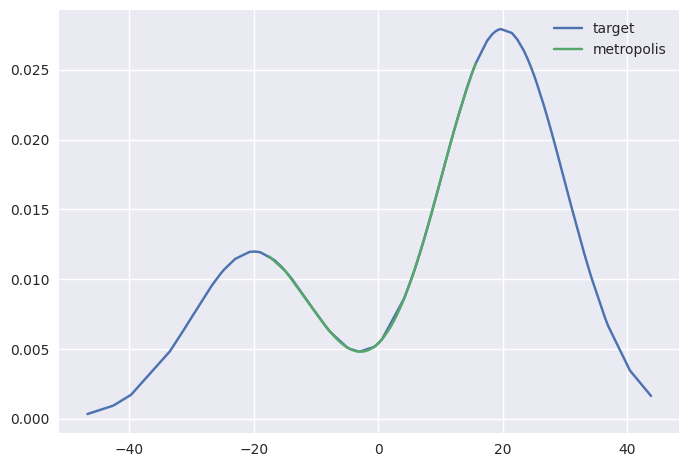

In [81]:
τ = torch.tensor(5.)
q = dist.Normal(0, τ)
target = gmm_target()
visualize(target, q, 1000)

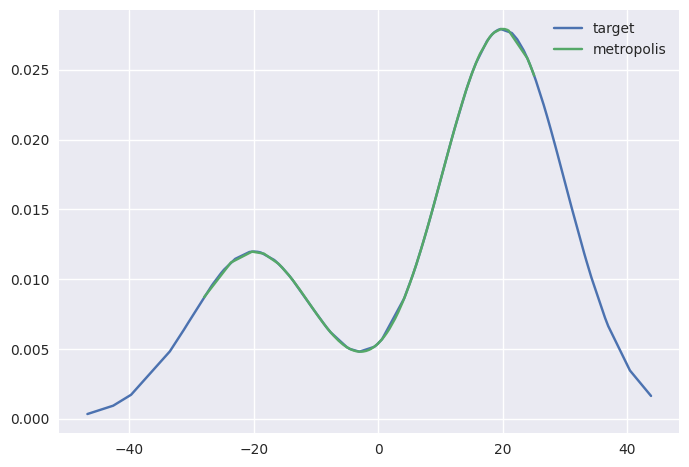

In [82]:
τ = torch.tensor(8.)
q = dist.Normal(0, τ)
target = gmm_target()
visualize(target, q, 1000)

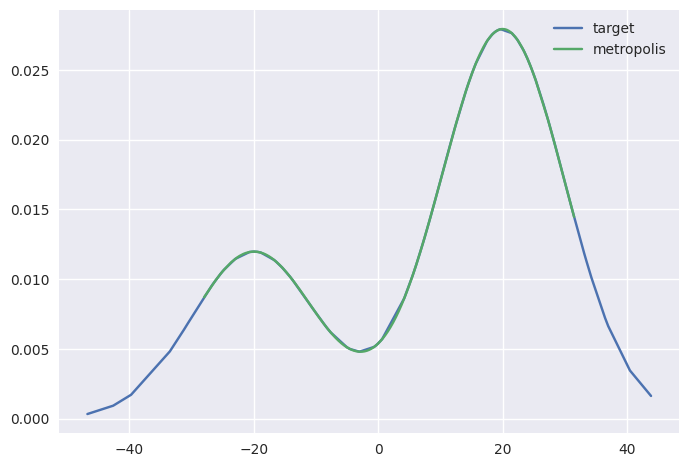

In [83]:
τ = torch.tensor(8.)
q = dist.Normal(0, τ)
target = gmm_target()
visualize(target, q, 10000)

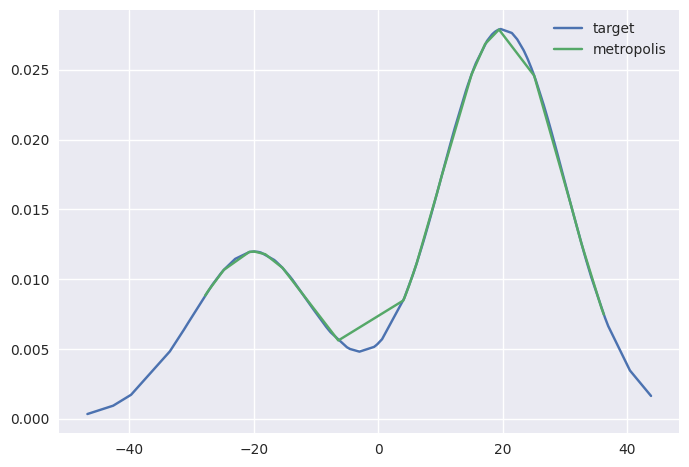

In [84]:
τ = torch.tensor(100.)
q = dist.Normal(0, τ)
target = gmm_target()
visualize(target, q, 100)

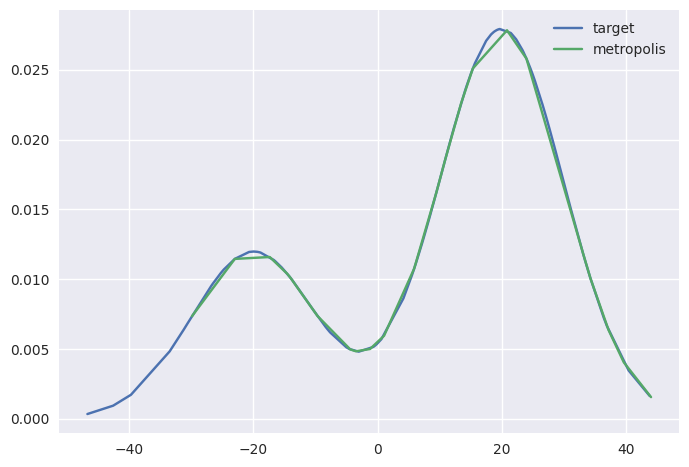

In [85]:
τ = torch.tensor(1000.)
q = dist.Normal(0, τ)
target = gmm_target()
visualize(target, q, 1000)

In [86]:
def gmm_gibbs_sampling(num_steps):
    x, z = torch.tensor(10.), torch.tensor(0).long()
    samples = {"x": [], "z": []}
    for i in range(num_steps):
        pz = torch.tensor([π[i] * comp_dist[i].log_prob(x).exp() for i in range(len(comp_dist))])
        pz /= pz.sum()
        zhat = dist.Categorical(pz).sample()
        xhat = comp_dist[zhat].sample()
        samples["x"].append(xhat.item())
        samples["z"].append(zhat.item())
    for k in samples:
        samples[k] = torch.tensor(samples[k])
    
    return samples

In [88]:
gmm_gibbs_sampling(300)["z"]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,